# Playground

In [1]:
# @TODO: preprocessing
# split "'" into two tokens
# remove tokens with <= 2 characters ????????????????

# findings are used as the report



The goal of this project is to generate medical reports from X-ray images. 
The Open-I X-ray image dataset with the corresponding medical reports will be used. The images are in grayscale. We will work on a few so-called *image2text* models. Previous work has explored using RNN with a co-attention mechanism. We'll primarily be exploring transformer models. In self-attention there is no need to extract "tags" as was the case for co-attention. Thus, the model has a larger degree of freedom to learn meaningful representations.

In [2]:
# @TODO: evaluation, BLEU, https://github.com/tylin/coco-caption (nltk library?)

# @TODO: visualize images by the resolution of sentences
# @TODO: colorize sentence confidence (lib?)

# @TODO: visualize self-attention (text) https://github.com/jessevig/bertviz

# @TODO: use larger encoder model (ViT-B/32, ViT-L/32, ViT-H/14) with 1024 hidden size
# @TODO: embedding (pre-trained?)

# @TODO: CNN vg199 (encoder)

# references: https://arxiv.org/pdf/1711.08195v3.pdf, https://arxiv.org/pdf/2209.15323.pdf

In [47]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

First the imports.

In [48]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision.models import vgg19, vit_b_16, ViT_B_16_Weights
from torchvision.transforms import Normalize

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

import spacy
#!python -m spacy download en_core_web_lg

import stanza

from utils import *
from dataset import *
from plots import *
from models import *

fix_seed()

stanza.download("en")

09:39:04 - INFO: Downloading default packages for language: en (English) ...
09:39:06 - INFO: File exists: /home/rasmus/stanza_resources/en/default.zip
09:39:11 - INFO: Finished downloading models and saved to /home/rasmus/stanza_resources.


## Load data

Let's load the metadata and the images.

In [5]:
REPORT_PATH = "./data/raw/reports"
IMAGE_PATH = "./data/raw/images"

In [6]:
metadata = load_reports(REPORT_PATH)
metadata.describe()

09:13:56 - INFO: found 3955 reports.


,patient_id
count,7470.000000
mean,1980.653681
std,1141.395698
min,0.000000
25%,998.000000
50%,1986.500000
75%,2968.750000
max,3954.000000


Notice, some of the text is censored by replacing words with "XXXX".

In [7]:
metadata.head()

,patient_id,image_name,comparison,indication,findings,impression
0,0,CXR82_IM-2350-3001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
1,0,CXR82_IM-2350-4001.png,Chest x-XXXX XXXX,PAIN IN THORACIC SPINE Pain started in leg are...,"No airspace disease, effusion or noncalcified ...",No acute cardiopulmonary abnormality.
2,1,CXR173_IM-0481-1001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
3,1,CXR173_IM-0481-2001.png,None,Chest pain,Low lung volumes. Cardiomediastinal silhouette...,Low lung volumes. No acute cardiopulmonary fin...
4,2,CXR3676_IM-1829-0001-0001.png,Comparison is XXXX to XXXX examination dated X...,XXXX-year-old male with XXXX.,The cardiomediastinal silhouette appears irreg...,1. Redemonstration of diffuse bilateral pulmon...


The feature "findings" describes the radiologists observations. While "impression" is the final diagnosis / conclusion.
Let's define a report as the concatation of the findings and impression text.

In [8]:
reports = prepare_reports(metadata)
reports.head()

09:13:57 - INFO: raw report length: 7470
09:13:57 - INFO: post-processing report length: 7430


0    No airspace disease, effusion or noncalcified ...
1    No airspace disease, effusion or noncalcified ...
2    Low lung volumes. Cardiomediastinal silhouette...
3    Low lung volumes. Cardiomediastinal silhouette...
4    The cardiomediastinal silhouette appears irreg...
Name: report, dtype: object

In [9]:
reports.describe()

count                                                  7430
unique                                                 3066
top       The heart is normal in size. The mediastinum i...
freq                                                     96
Name: report, dtype: object

Let's load the images. The images have been cropped such that the width and height are the same. Afterwards, the images have been downscaled to 256x256. 

In [10]:
# we'll only use a subset of the dataset in the *notebook* due to memory constraints. However, the scripts will use the full dataset.
N = 1000

metadata_subset = metadata[:N]
reports_subset = prepare_reports(metadata_subset)

images = load_images(metadata_subset, IMAGE_PATH, resized=(224, 224))
images = images[reports_subset.index]

09:13:57 - INFO: raw report length: 1000
09:13:57 - INFO: post-processing report length: 996


There are images from two views: frontal and lateral. It may be worth to include this information in the model. However, since the view hasn't already been annotated, we will ignore it for now.

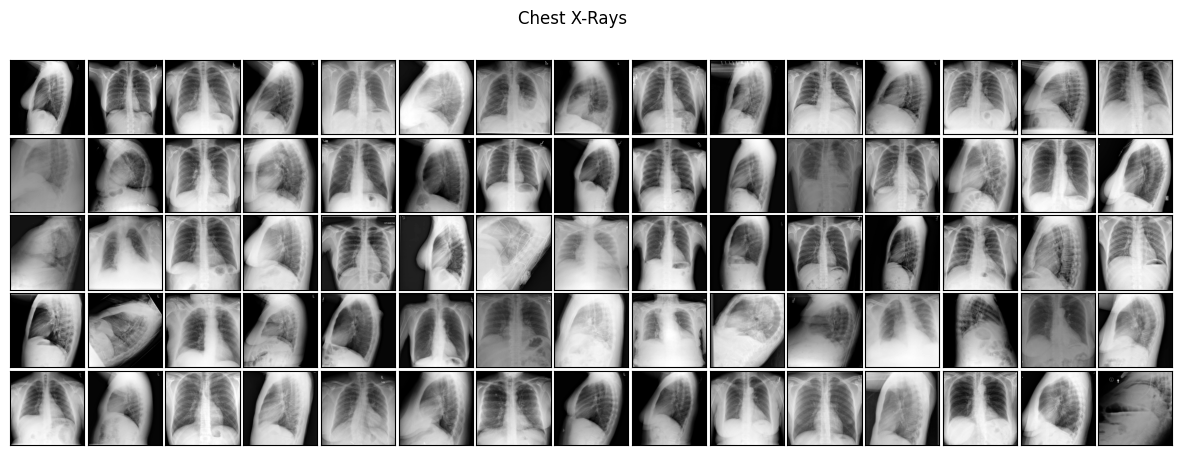

In [11]:
offset = 100
n_rows = 5
n_cols = 15

images_tiny = images[offset:offset+n_rows*n_cols]

plot_images_2d(images_tiny.reshape(n_rows, n_cols, *images_tiny.shape[1:]), "Chest X-Rays")

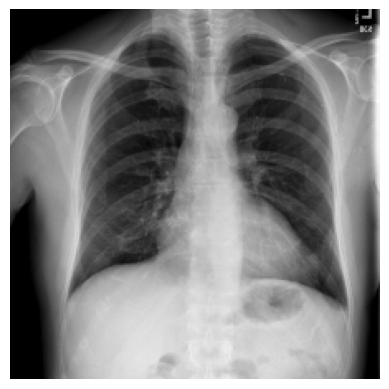

In [12]:
highlighted_image = images[0]
plot_image(highlighted_image)

Time to plot a few random X-ray image and their corresponding reports!

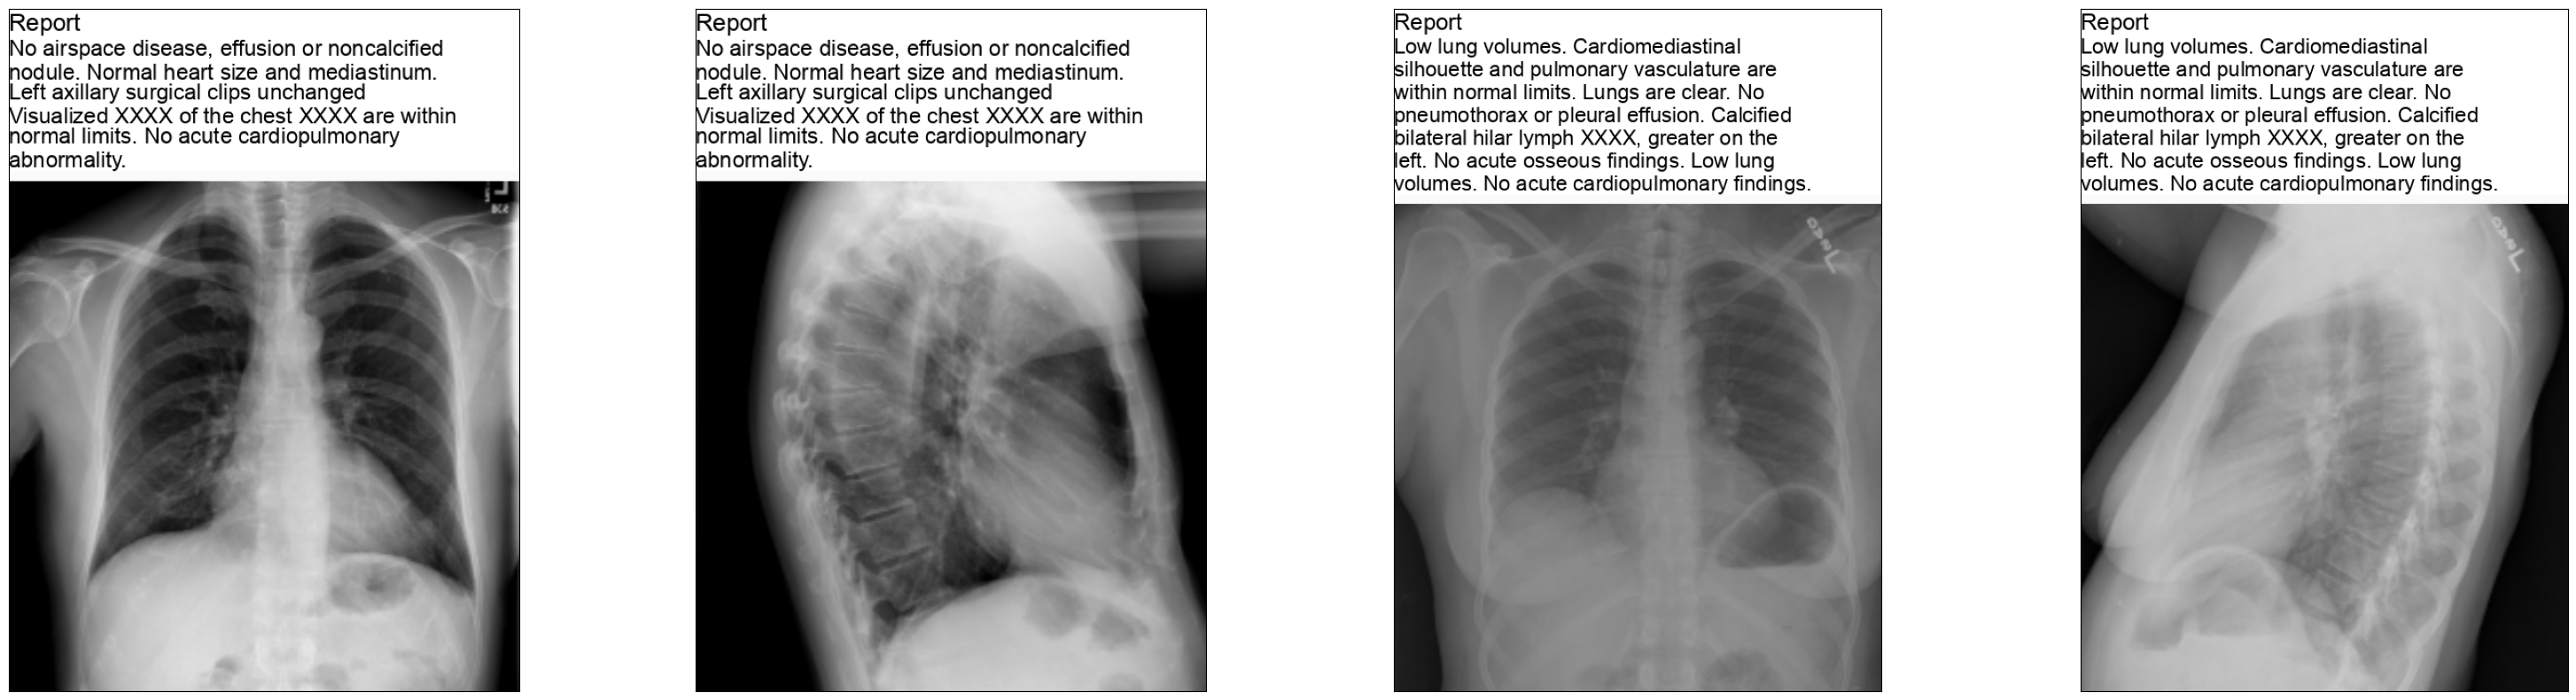

In [13]:
k = np.arange(4) #1400

title = "Report"
extracted_textbodies = reports.iloc[k]
extracted_images = images[k].numpy()

plot_multiple_text_and_images(extracted_textbodies, title, extracted_images)

## Preprocessing

### Images

Images are already normalized the range [0, 1]. The models may also do some more prepocessing of the images as some of them are pretrained model. Preprocessing includes z-score normalization. 

### Text

Let's tokenize the reports.

In [14]:
#tokenizer = spacy_tokenizer()
tokenizer = stanza_tokenizer()

tokenized_reports = reports.apply(lambda text : tokenize(text, tokenizer))

09:14:07 - INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


09:14:07 - WARNING: Can not find mwt: default from official model list. Ignoring it.
09:14:07 - INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

09:14:07 - INFO: Using device: cpu
09:14:07 - INFO: Loading: tokenize
09:14:07 - INFO: Done loading processors!


And time for some statistics:

In [15]:
tokenized_reports.head()

0    [no, airspace, disease, effusion, or, noncalci...
1    [no, airspace, disease, effusion, or, noncalci...
2    [low, lung, volumes, ., cardiomediastinal, sil...
3    [low, lung, volumes, ., cardiomediastinal, sil...
4    [the, cardiomediastinal, silhouette, appears, ...
Name: report, dtype: object

In [16]:
tokenized_reports_lengths = tokenized_reports.apply(len)

print(f"Report length: {np.mean(tokenized_reports_lengths):.1f} +- {np.std(tokenized_reports_lengths):.1f} words.")
print(f"Report length boundaries: [{np.min(tokenized_reports_lengths):.1f}; {np.max(tokenized_reports_lengths):.1f}] words.")

Report length: 42.5 +- 21.0 words.
Report length boundaries: [3.0; 248.0] words.


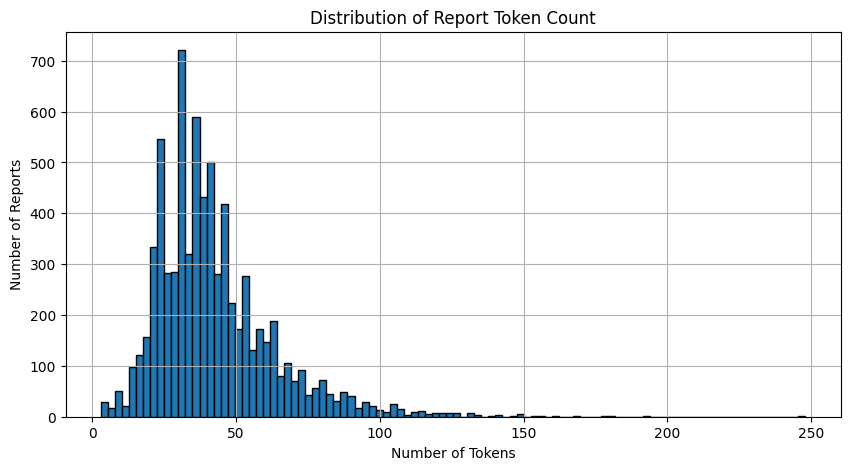

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(tokenized_reports_lengths, bins=100, histtype="bar", ec="black")
ax.set_title("Distribution of Report Token Count")
ax.set_xlabel("Number of Tokens")
ax.set_ylabel("Number of Reports")
ax.grid()
plt.show()

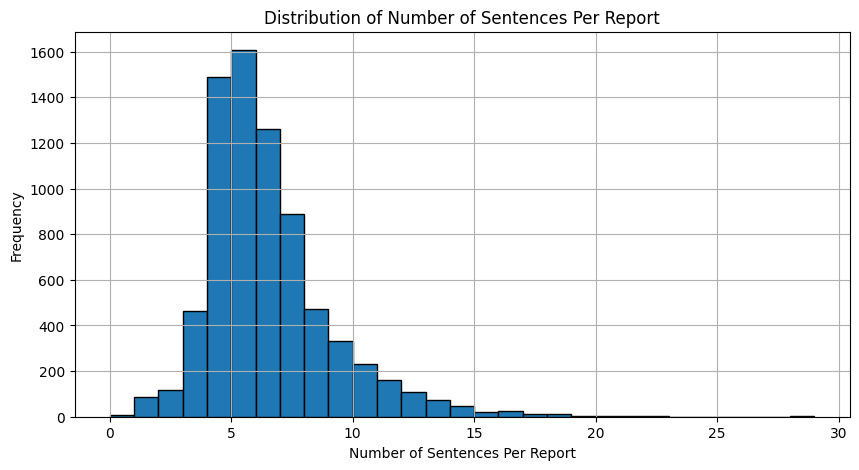

In [18]:
sentences = []
for token_ids in tokenized_reports:
    n_sentences = np.sum([1 for token in token_ids if token == "."])
    sentences.append(n_sentences)

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentences, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Number of Sentences Per Report")
ax.set_xlabel("Number of Sentences Per Report")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

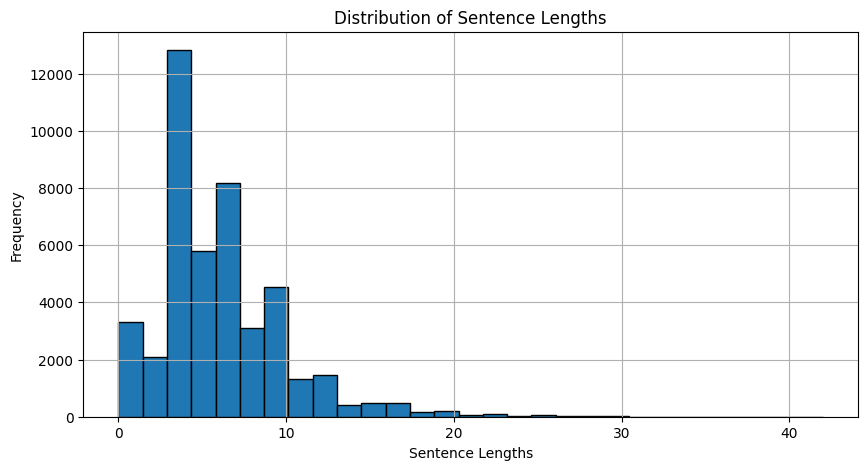

In [19]:
sentence_lengths = []
for token_ids in tokenized_reports:
    sentence_length = 0
    for token_id in token_ids:
        if token_id == ".":
            sentence_lengths.append(sentence_length)
            sentence_length = 0
        else:
            sentence_length += 1


fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sentence_lengths, bins=max(sentences), histtype="bar", ec="black")
ax.set_title("Distribution of Sentence Lengths")
ax.set_xlabel("Sentence Lengths")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

Let's look at the most common words in the reports.

In [20]:
token_counts = {}
for token_ids in tokenized_reports:
    for token_id in token_ids:
        if token_id in token_counts:
            token_counts[token_id] += 1
        else:
            token_counts[token_id] = 1

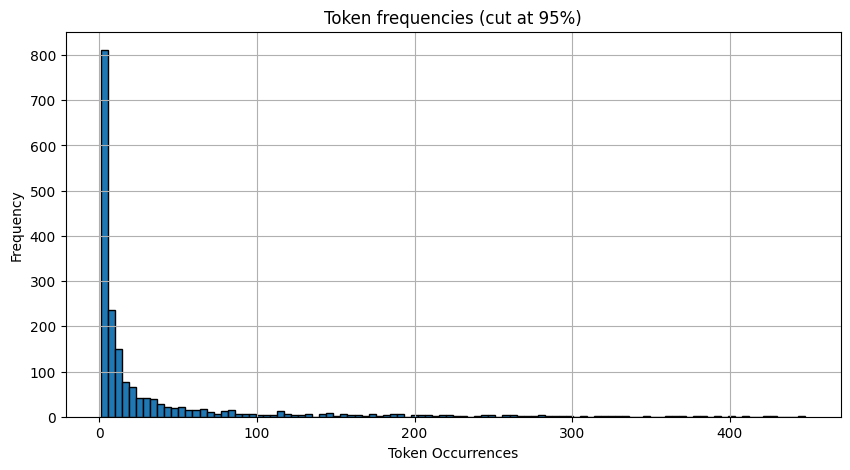

In [21]:
token_frequencies = [token_counts[token_id] for token_id in token_counts]
token_frequencies.sort(reverse=True)

cut_percent = 0.95
cut = (int)(len(token_frequencies)*(1-cut_percent))
token_frequencies = token_frequencies[cut:]
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(token_frequencies, bins=100, histtype="bar", ec="black")
ax.set_title(f"Token frequencies (cut at {cut_percent*100:.0f}%)")
ax.set_xlabel("Token Occurrences")
ax.set_ylabel("Frequency")
ax.grid()
plt.show()

Our dataset is small, and since most of the words are very infrequent, we will be using pre-trained embeddings.

Let's see the most frequent tokens:

In [22]:
token_ids = [token_id for token_id in token_counts]
token_ids.sort(key=lambda token_id : token_counts[token_id], reverse=True)

N = 20

for token_id in token_ids[:N]:
    print(f"{token_id} ({token_counts[token_id]})")

. (44679)
no (14553)
the (13438)
is (8946)
are (8761)
normal (7720)
of (6426)
and (6412)
acute (5818)
pleural (5430)
or (5427)
pneumothorax (4896)
effusion (4793)
there (4744)
heart (4732)
lungs (4528)
size (4304)
focal (3663)
clear (3608)
pulmonary (3237)


and the size of the vocabulary...

In [23]:
vocabulary = build_vocabulary([token for tokens in tokenized_reports for token in tokens])
print(f"vocabulary size: {len(vocabulary)} tokens")

token2id, id2token = map_token_and_id(vocabulary)

vocabulary size: 1932 tokens


## Models

Time for training...

In [24]:
#model_name = "playground"
#model = XRayPlaygroundModel(len(vocabulary))

model_name = "vit"
model = XRayViTModel(len(vocabulary), num_transformer_layers=3)

images_ready = model.encoder.preprocess(images)

train_test_split = .9
train_validation_split = .9

#size = len(images)
size = 6

total_train_size = int(size * train_test_split)
train_size = int(total_train_size * train_validation_split)
train_end = size+1

train_dataset = XRayDataset(images_ready[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images_ready[train_size:total_train_size], tokenized_reports[train_size:total_train_size], token2id)
test_dataset = XRayDataset(images_ready[total_train_size:train_end], tokenized_reports[total_train_size:train_end], token2id)

/home/rasmus/anaconda3/envs/xray/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
train(model_name, model, vocabulary, train_dataset, validation_dataset, epochs=50, batch_size=16, lr=1e-2, weight_decay=0)

result_path = os.path.join("results", model_name, "result.pkl")
result = load_dict(result_path)
result["test_loss"] = evaluate(model, validation_dataset, token2id)
save_dict(result, result_path)

Actually, the model is already trained. Let's load the weights and evalulate the performance.

In [144]:
model.load_state_dict(torch.load(os.path.join("results", model_name, "model.pt"), map_location=torch.device("cpu")))

result = load_dict(os.path.join("results", model_name, "result.pkl"))

train_losses = result["train_losses"]
validation_losses = result["validation_losses"]

train_loss = train_losses[-1]
validation_loss = validation_losses[-1]
test_loss = result["test_loss"]

accuracy = lambda loss: np.exp(-loss)
perplexity = lambda loss: np.exp(loss)

loss_random = -np.log(1 / len(vocabulary))

print(f"loss | train: {train_loss:.3f}, validation: {validation_loss:.3f}, test: {test_loss:.3f}, random: {loss_random:.3f}")
print(f"perplexity | train: {perplexity(train_loss):.3f}, validation: {perplexity(validation_loss):.3f}, test: {perplexity(test_loss):.3f}, random: {perplexity(loss_random):.3f}")
print(f"accuracy | train: {accuracy(train_loss):.4f}, validation: {accuracy(validation_loss):.4f}, test: {accuracy(test_loss):.3f}, random: {accuracy(loss_random):.4f}")

perplexity | train: 1.440, validation: 2777.414, test: 2777.414, random: 1933.000
accuracy | train: 0.6946, validation: 0.0004, test: 0.000, random: 0.0005


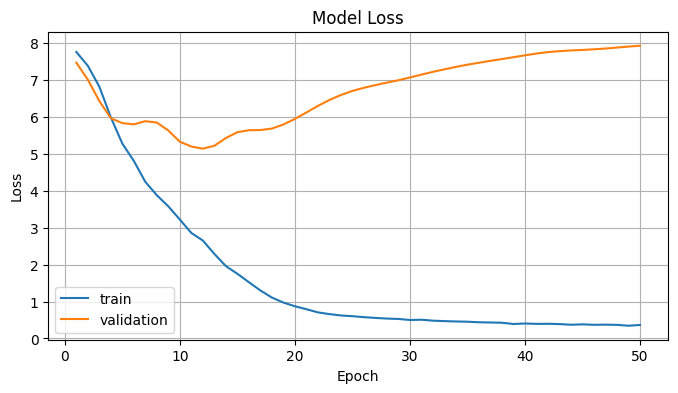

In [145]:
plot_losses(train_losses, validation_losses)

## Evaluation

Time to generate some reports!

In [146]:
def vit_emit(model, image):
    # persistent state to speed-up sampling
    with torch.no_grad():
        model.eval()
        context = model.encoder(image[None])

    # define emitter
    def emitter(tokens):
        with torch.no_grad():
            model.eval()
            out = model.decoder(tokens[None], context) # add batch dim
        return F.log_softmax(out[0,-1,:], dim=-1)
    
    return emitter


def playground_emit(model, image):
    # persistent state to speed-up sampling
    with torch.no_grad():
        model.eval()
        context = model.encoder(image[None])

    # define emitter
    def emitter(tokens):
        with torch.no_grad():
            model.eval()
            out, _ = model.decoder(tokens[None], context) # add batch dim
        return F.log_softmax(out[0,-1,:], dim=-1)
    
    return emitter

In [147]:
def prob_sample(emit_fn, token2id, max_length=100):
    start_token = token2id["[START]"]
    token_ids = [start_token]

    for _ in range(1, max_length):
        scores = emit_fn(torch.tensor(token_ids))

        p = F.softmax(scores, dim=-1).numpy().astype(np.float64)
        p /= np.sum(p)

        token_id = torch.tensor(np.random.choice(len(scores), p=p))
        token_ids.append(token_id.item())

        if token_id == token2id["[END]"]:
            break

    return token_ids


def beam_search(emit_fn, token2id, beam_width=5, max_length=100):
    start_token = token2id["[START]"]

    beams = [(0, [start_token]) for _ in range(beam_width)] # (score, tokens)
    done = []

    scores = emit_fn(torch.tensor([start_token]))
    _, top_idx = scores.topk(beam_width)
    for idx, (score, token_ids) in enumerate(beams):
        top_id = top_idx[idx]
        beams[idx] = (score + scores[top_id].item(), token_ids + [top_id.item()])

    vocab_size = scores.shape[-1]

    for _ in range(2, max_length):
        beam_width = len(beams)

        if beam_width == 0:
            break
        
        all_token_ids = [token_ids for _, token_ids in beams]
        all_scores = torch.tensor([score for score, _ in beams]).reshape((beam_width, 1))
        all_scores = all_scores.expand((beam_width, vocab_size)).clone()

        for idx, (score, token_ids) in enumerate(beams):
            scores = emit_fn(torch.tensor(token_ids))
            all_scores[idx] += scores

        _, top_idx = all_scores.flatten().topk(beam_width)

        beam_ids = top_idx // vocab_size
        token_ids = top_idx % vocab_size

        for idx in range(beam_width):
            beam_id, token_id = beam_ids[idx], token_ids[idx]
            new_score = all_scores[beam_id, token_id].item()
            new_token_ids = all_token_ids[beam_id] + [token_id.item()]
            beams[idx] = (new_score, new_token_ids)

        done += [(score, token_ids) for (score, token_ids) in beams if token_ids[-1] == token2id["[END]"]]
        beams = [(score, token_ids) for (score, token_ids) in beams if token_ids[-1] != token2id["[END]"]]

    done.extend(beams)

    return done

true: the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. normal chest.
guess: [START] the right upper lung. [END]


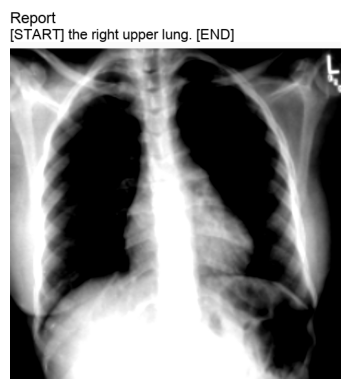

In [148]:
sample_idx = 1
x, report_ids, _ = train_dataset[sample_idx]

emit = vit_emit(model, x)
#emit = playground_emit(model, xray)

target = [id2token[token] for token in report_ids[1:-1]]

generated_ids = prob_sample(emit, token2id, max_length=75)
generated = [id2token[token] for token in generated_ids]

report = tokens_to_text(target)
report_est = tokens_to_text(generated)

print(f"true: {report}")
print(f"guess: {report_est}")

xray_plotable = x[0].numpy()
plot_text_and_image(report_est, "Report", xray_plotable)

In [149]:
beams = beam_search(emit, token2id, beam_width=5, max_length=75)

for beam in beams:
    print(tokens_to_text([id2token[id] for id in beam[1]]))

[START] the right upper lung. [END]
[START] the lungs are within normal limits. [END]
[START] the lungs are within normal limits for size are within normal limits. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there
[START] the lungs are within normal limits for size and mediastinum size are within normal limits. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal consolidation. there is no focal
[START] the lungs are within normal limits for size and mediastinum size are within no

Let's explore where the transformer model puts it attention on the image. 

In [152]:
print(model.decoder.decoder_layer1.mha_weights.shape)

torch.Size([1, 44, 197])


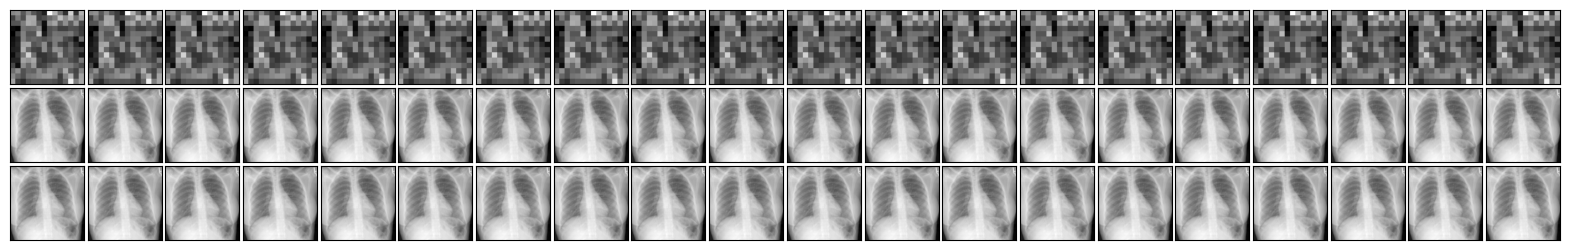

In [151]:
# @TODO: don't use the avg attention between all n heads?

N_words = 20
_, = model(torch.tensor(report_ids)[None], x[None])
attention_weights_tokens = model.decoder.decoder_layer1.mha_weights[0][:N_words].detach().numpy()

image_attentions = np.empty((attention_weights_tokens.shape[0], 3, 224, 224))
for i, attention_weights in enumerate(attention_weights_tokens):
    image_attention_mask = create_avg_image_attention_mask(attention_weights_tokens[:,1:], xray_plotable.shape, (14, 14))
    image_attentions[i] = np.array([image_attention_mask, xray_plotable, image_attention_mask * xray_plotable])

plot_images_2d(image_attentions.transpose(1,0,2,3))

In [5]:
# https://machinelearningmastery.com/calculate-bleu-score-for-text-python/

from nltk.translate.bleu_score import corpus_bleu

references = [[['this', 'is', 'a', 'test'], ['this', 'is' 'test']]]
candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(references, candidates)
print(score)

1.0


## Misc

In [125]:
out = model(torch.tensor(report_ids)[None], x[None])
token_ids = out.argmax(dim=-1)

token_ids = [id2token[id.item()] for id in token_ids[0]]
tokens_to_text(token_ids)

'the cardiac silhouette and mediastinum size are within normal limits. there is no focal edema. there is no focal consolidation. there is within focal of a pleural effusion. there is no focal of a. there limits. there.'

In [542]:
model.decoder.decoder_layer1.sa_weights.shape

torch.Size([1, 44, 44])

## A New Way

In [25]:
chexnet = load_CheXNet()

In [26]:
glove_vectors = download_glove()

09:15:02 - INFO: loading projection weights from /home/rasmus/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz
09:16:02 - INFO: KeyedVectors lifecycle event {'msg': 'loaded (400000, 300) matrix of type float32 from /home/rasmus/gensim-data/glove-wiki-gigaword-300/glove-wiki-gigaword-300.gz', 'binary': False, 'encoding': 'utf8', 'datetime': '2023-04-10T21:16:02.587150', 'gensim': '4.3.1', 'python': '3.10.9 (main, Mar  8 2023, 10:47:38) [GCC 11.2.0]', 'platform': 'Linux-5.10.0-18-amd64-x86_64-with-glibc2.31', 'event': 'load_word2vec_format'}


In [27]:
embed = get_word_embeddings(token2id, glove_vectors)
embed.shape

(1932, 300)

In [28]:
unknown_tokens_embeddings = [token for token in vocabulary if token not in glove_vectors]
print(f"Number of tokens not in GloVe: {len(unknown_tokens_embeddings)}")

Number of tokens not in GloVe: 273


In [88]:
model = CheXNetBaseNet(embed, hidden_size=256)

In [93]:
train_test_split = .9
train_validation_split = .9

#size = len(images)
size = 6

images_ready = model.encoder.preprocess(images[:size])

total_train_size = int(size * train_test_split)
train_size = int(total_train_size * train_validation_split)
train_end = size+1

train_dataset = XRayDataset(images_ready[:train_size], tokenized_reports[:train_size], token2id)
validation_dataset = XRayDataset(images_ready[train_size:total_train_size], tokenized_reports[train_size:total_train_size], token2id)
test_dataset = XRayDataset(images_ready[total_train_size:train_end], tokenized_reports[total_train_size:train_end], token2id)

In [94]:
a = torch.empty((1,256))
b = a.unsqueeze(1).expand((-1, 35, -1))
b.shape

torch.Size([1, 35, 256])

In [95]:
print(b[0, 3, 2], b[0, 18, 2], b[0, 30, 2])

tensor(0.) tensor(0.) tensor(0.)


In [96]:
xray, report_ids, _ = train_dataset[0]
out = model(torch.tensor(report_ids)[None], xray[None])

torch.Size([1, 35, 256]) torch.Size([1, 35, 256])
torch.Size([1, 35, 512])


In [39]:
out.shape

torch.Size([1, 1932])

In [1]:
!pip install nltk

     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.5 MB 991.0 kB/s eta 0:00:02
     ---- ----------------------------------- 0.2/1.5 MB 1.7 MB/s eta 0:00:01
     -------- ------------------------------- 0.3/1.5 MB 2.3 MB/s eta 0:00:01
     ---------------- ----------------------- 0.6/1.5 MB 3.3 MB/s eta 0:00:01
     ------------------------------- -------- 1.2/1.5 MB 5.1 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/298.0 kB ? eta -:--:--
     -------------------------------------- 298.0/298.0 kB 9.3 MB/s eta 0:00:00
     ---------------------------------------- 0.0/267.9 kB ? eta -:--:--
     ------------------------------------- 267.9/267.9 kB 17.2 MB/s eta 0:00:00
